In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
os.getcwd()

'/home/joonas/Documents/P29/grid_congestion_manager-main'

In [3]:
os.chdir('/home/joonas/Documents/P29/grid_congestion_manager-main')
#os.chdir('/Users/ilmaruduste/School/Masinõpe') #Ilmar
#os.chdir('E:\ML\grid_congestion_manager') #Sille PC

In [4]:
grid_load = pd.read_csv('grid_congestion_data/gridload.csv')
grid_locations = pd.read_csv('grid_congestion_data/grid_locations.csv')
ev_home = pd.read_csv('grid_congestion_data/ev_home_locations.csv')
public_chargers = pd.read_csv('grid_congestion_data/public_chargers_locations.csv')
ev_history = pd.read_csv('grid_congestion_data/ev_history.csv')
cars = pd.read_csv('grid_congestion_data/ev_models.csv')

### CLUSTERING

In [5]:
# find eucleidian distance between points (x1, y1) and (x2, y2)
def x_y_distance(x1, y1, x2, y2):
    return np.sqrt((x1-x2)**2 + (y1-y2)**2) 

# method adds closest grid cadaster to dataframe
def closest_grid_cadaster(location, grid):
    closest_grids = [] # list used to update dataframe later
    
    # iter over all locations
    for l in location.iterrows():
        # temp variables
        min_distance = None
        closest_grid = None
        
        # find distance from location l to all grids g
        for g in grid.iterrows():
            distance = x_y_distance(l[1].x, l[1].y, g[1].x, g[1].y)
            
            # if closer than previous closest grid, then overwrite
            if min_distance == None or distance < min_distance:
                min_distance = distance
                closest_grid = g[1].cadaster
                
        closest_grids.append(closest_grid)
    
    #update dataframe
    location.loc[:,"closest_grid_cadaster"] = closest_grids
    
closest_grid_cadaster(ev_home, grid_locations)
closest_grid_cadaster(public_chargers, grid_locations)

### SUBSTATION LOADS PROCESSING

In [6]:
#calculating baseloads

cadasters = grid_load['cadaster'].unique()
baseloads = dict()

for cadaster in cadasters: # lets make a empty dict with correct structure
    one_day_loads = np.zeros((24)) #24 hours in a day
    baseloads[cadaster] = one_day_loads

for index, row in grid_load.iterrows(): #insert correct elements into dict
    
    baseloads[row['cadaster']][row['time']-1] = row['baseload']


In [7]:
#make dict with different car model's chargning powers
charging_powers = dict()
for index, row in cars.iterrows():
    
    charging_powers[row['models']] = row['charge_power']

In [8]:
#make dict with loads from ev charging
ev_loads = dict()
for cadaster in cadasters: 
    one_day_loads = np.zeros((24)) #24 hours in a day
    ev_loads[cadaster] = one_day_loads

for index, row in ev_history.iterrows(): #scan over history
    if row['connected'] == True and row['charge_need'] != 0: #check if car is connected and needs charge
        
        cadaster_of_interest = row['cadaster'] #have to find out whats the closest substation for this cadaster
        
        for index, public_row in public_chargers.iterrows(): #scan public chargers
            if public_row['cadaster'] == cadaster_of_interest:
                ev_loads[public_row['closest_grid_cadaster']][row['time']-1] += charging_powers[row['model']]
                break     
        
        for index, home_row in ev_home.iterrows(): #scan home chargers
            if public_row['cadaster'] == cadaster_of_interest:
                ev_loads[home_row['closest_grid_cadaster']][row['time']-1] += charging_powers[row['model']]
                break

In [9]:
power_limits = dict()

for index, row in grid_locations.iterrows():
    power_limits[row['cadaster']] = row['max_current']

### LEGEND

In [10]:
#cadasters #all cadasters for substations
#baseloads #dictionary for baseloads for each substation (key: cadaster, value: 24 element array)
#ev_loads #dictionary for ev charging loads for each substation (key: cadaster, value: 24 element array)
#power_limits #dictionary for power limits for each substation (key: cadaster, value: 24 element array)

### EXAMPLE

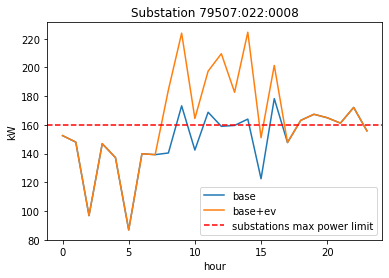

lol, see on alajaam on juba eos lappes


In [23]:
plt.plot(baseloads['79507:022:0008'], label = 'base')
plt.xlabel('hour')
plt.ylabel('kW')
plt.title('Substation 79507:022:0008')
plt.plot(baseloads['79507:022:0008']+ev_loads['79507:022:0008'], label = 'base+ev')
plt.axhline(y=power_limits['79507:022:0008'], color='r', linestyle='--',label = 'substations max power limit')
plt.legend()
plt.show()
print('lol, see on alajaam on juba eos lappes')